In [301]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.fftpack import fft, ifft

In [537]:
def Window(ts):
    '''This function applies a parabolic window to the signal input'''
    n = len(ts) #n is length of time series
    W = np.zeros((n,1)) #initialize empty array
    #create parabola from 0 to length n
    for j in np.arange(0,n):
        W[j] = 1 - np.power((2*(j + 1)/(n+1)-1),2)
    #multiply parabola and signal to get windowed signal (result)
    result = ts * W 
    return result

def Bridge(ts):
    '''This function applies the bridge detrended method to the signal input'''
    n = len(ts)
    #points is the length of the time series from n-1 to 0 (backwards i.e. n-1, n-2,...0)
    points = np.arange(n-1, -1, -1).reshape(1,n)
    #line connecting first and last point
    line = ((ts[0]-ts[n-1])*points/(n-1))+ts[n-1]
    line = line.transpose() #transposes line from row to column array
    #subtract line from time series to return bridge detrended signal (result)
    result = ts - line
    return result 

def Linreg(x,y):
    '''This function calculates the slope and correlation coeff of a linear fit
    Result[0]: Slope
    Result[1]: Correlation coefficient'''
    #calculate mean of x and y (lgfrek and lgPyy when called in FracTool)
    mikro = np.mean(x) #mean of lgfrek
    nu = np.mean(y) #mean of lgPyy
    mikro_sub = x - mikro #subtract lgfrek mean from lgfrek array 
    nu_sub = y - nu #subtract lgPyy mean from lgPyy
    #multiply arrays and add sum of elements 
    Qxy = np.sum(mikro_sub*nu_sub)
    Qx = sum(mikro_sub**2) #sum of sqaured differences of lgfrek
    Qy = sum((nu_sub**2)) #sum of squared differences of lgPyy
    result = np.empty([2,1]) #initialize empty result array
    result[0] = Qxy/Qx #slope of linear regression
    result[1] = Qxy/(Qx*Qy)**0.5 #correlation coefficient of linear regression
    
    return result
 
    

def Spec(ts, p, avg): 
    '''This function performs a spectral analysis of the time series
    where ts is the time series, p is the nth power of 2 where 2^n<=length
    of time series. If avg=0, then spectra for all, if avg=1, then spectra avg.
    An array of the following results will be returned.
    result(0): Hurst coefficient
    result(1): correlation coefficient
    result(2): beta from Fourier analysis
    result(3): Hurst coefficient (high freq excluded)
    result(4): correlation coefficient (high freq excluded)
    result(5): beta from Fourier analysis (high freq excluded)'''
    #initialize empty array for results outlined above
    result = np.empty([6,1])
    f = 1
    n = 2**p
    #compute the estimated power of time series (Pyy)
    #compute the discrete fourier transform of time series 
    Y = scipy.fftpack.fft(ts.flatten()) #time series needs to be 1D (flattened from 2D)
    Pyy = Y*np.divide(Y.conj(),n) #divide the conjucate of the fourier transform by n 
    Pyy = Pyy[0:int(n/2)] #splice array to only include have first half (it is symmetric)
    Pyy = np.reshape(Pyy, (Pyy.size,1)) #convert Pyy to column array
    
    #clear Y and y arrays
    Y = []
    y = []
    
    #generate array of frequencies from 0 to 0.5 (frek)
    frek = f/n*np.arange(1,(n/2)+1)
    frek = np.reshape(frek, (frek.size,1)) #transpose frek to column array 
        
    #if avg=1, then average frek and Pyy before taking spectra
    if avg == 1: 
        #initialize empty 1D arrays
        ff = np.zeros((1,p-1)).flatten()
        pp = np.zeros((1,p-1)).flatten()
        for i in range(1,p):
            #each element in ff is mean of frek from 2^(i-1) to (2^i) - 1 until i = p
            ff[i-1]=np.mean(frek[2**(i-1)-1:2**i-1])
            #each element in pp is mean of Pyy from 2^(i-1) to (2^i) - 1 until i = p
            pp[i-1]=np.mean(Pyy[2**(i-1)-1:2**i-1])
        #clear Pyy and frek and set value to pp and ff omitting first index
        Pyy=[] #clear Pyy
        Pyy = pp[1:len(pp)]
        Pyy = np.reshape(Pyy, (Pyy.size,1)) #convert into 2D array
        frek=[] #clear frek
        frek=ff[1:len(pp)]
        frek = np.reshape(frek,(frek.size,1)) #convert into 2D array
        #now spectra will be of average, not all (when avg=0)
      

    #find where Pyy has values of 0, set those values to 0.00001 before taking log
    k = np.where(Pyy==0)
    if len(k)!=0: #if there are values where Pyy = 0
        for kk in range(1,len(k)+1):
            Pyy[k[kk-1]] = 0.00001
            
    #take natural log of Pyy and frek
    lgPyy = np.log(Pyy)
    lgfrek = np.log(frek)
    
    #power spectral density (PSD) plot 
    plt.plot(lgfrek,lgPyy)
    plt.title('PSD Before High Freq Excluded')
    plt.show()
    
    #compute linear regression of PSD
    #curvefit returns an array of 2 values: (1) slope from lin regression, (2) correlation coeff from lin regression
    curvefit = Linreg(lgfrek,lgPyy)
    #set result values to curvefit results (according to indices outlined in function definition)
    result[2] = curvefit[0,0]*-1  #Beta, multiplying by -1 makes the slope positive
    result[1] = curvefit[1,0]   #Correlation coeff
    #calculate Hurst coefficient based on value of Beta
    if result[2]<1: #if Beta is less than 1
        result[0] = (result[2]+1)/2
    elif result[2]>1: #if Beta is greater than 1
        result[0] = (result[2]-1)/2
    elif result[2]==1: #if Beta is equal to 1, set Hurst to infinity
        result[0] = inf 
   
    #if avg=1, then exclue the last two values of lgfrek and lgPyy and then perform linear regression
    if avg == 1: 
        curvefit = Linreg(lgfrek[0:len(lgfrek)-2], lgPyy[0:len(lgPyy)-2])
    
    #if avg=0, exclude frequencies from 0.125Hz-0.5Hz and then perform linear regression 
    else:
        curvefit = Linreg(lgfrek[0:int(np.floor(len(lgfrek)/4))],lgPyy[0:int(np.floor(len(lgPyy)/4))])
    
    #plot of PSD after high frequencies are excluded
    plt.plot(lgfrek[0:int(np.floor(len(lgfrek)/4))],lgPyy[0:int(np.floor(len(lgPyy)/4))])
    plt.title('PSD After High Freq Excluded')
    plt.show
    
    #results of curvefit with high frequencies excluded
    result[5] = curvefit[0]*-1 #Beta
    result[4] = curvefit[1] #correlation coefficient
    
    #determine Hurst coefficient from Beta found after excluding high frequencies
    if result[5]<1: #if Beta is less than 1
        result[3] = (result[5]+1)/2
    elif result[5]>1: #if Beta is greater than 1
        result[3] = (result[5]-1)/2
    elif result[5]==1: #if Beta is equal to 1, set Hurst coefficient to infinity 
        result[0] = inf 
        
    return result #result is array of 6 values

    
    
def FracTool(ts):
    '''This function will aid time series analysis using the concept 
     of statistical fractals.
     This code is adapted from A. Eke, P. Hermán, J. B. Bassingthwaighte, G. M. Raymond, D. B. Percival, 
     M. Cannon, I. Balla, and C. Ikrényi. Physiological time series: distinguishing 
     fractal noises from motions. Pflügers Archiv European Journal of 
     Physiology,4394):403-415, 2000. 
     Fractool determines: 
     1) The signal class of the time series according to the fGn/fBm model
     2) The Hurst coefficients for the fGn or fBm time series
     The input ts is a time series of a single coloumn of data points
    '''
    assert (len(ts) !=0), 'time series is empty'
    
    #INITIALIZATION 
    H_PSD = -1
    H_Disp = -1
    H_bdSWV = -1
    H_fGn = -1
    H_fBm = -1
    
    #parameters 
    n=len(ts) #length of time series input
    print('Number of raw time-points = ', n)
    i = 1
    while n >= 2**i: #calculates the closest 2^i value in n 
        i += 1
    p = i - 1
    tsid = ts[0:2**p] #splices time series to exclue points after 2^p
    print('Number of time-points after 2^p splice =', 2**p)
    del ts #delete signal before splice (the raw time series)
    signal_mean = np.mean(tsid) #get mean of spliced time series
    print('Mean of time series = ', signal_mean)
    n = len(tsid) #update n to length of tsid
    
    #get Beta value using lowPSDw,e method (w:windowing, e:endmatching, low:excluding high frequencies)
    #apply parabolic window, then bridge detrend the time series
    #calculate spectra estimates excluding frequencies between 1/8 and 1/2
    #Beta is the slope of the regression of the spectral estimates
    result = Spec(Bridge(Window(tsid)),p,0)
    #print statements are of results when excluding high frequencies
    print('Beta = ', result[5,0])
    print('Correlation coeff = ', result[4,0])

Number of raw time-points =  1024
Number of time-points after 2^p splice = 1024
Mean of time series =  -23.59470008156738


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


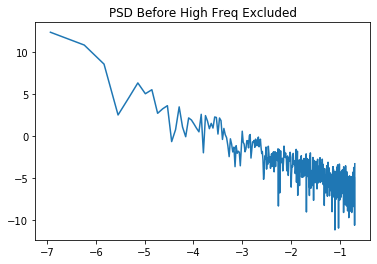

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Beta =  2.766787296478325
Correlation coeff =  -0.8829373563591978


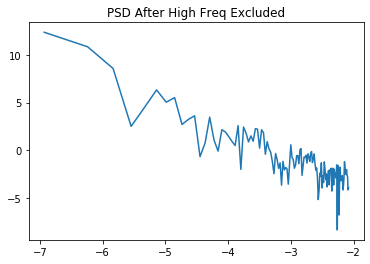

In [538]:
#Load signal from sample fMRI (SCI_Pilot_08)
#these signals have a grey mask applied
fbm_sample = np.loadtxt(fname="Test_Signals/sig_fbm_sample.csv", delimiter =",")
fgn_sample = np.loadtxt(fname="Test_Signals/sig_fGn_sample.csv", delimiter =",")
SSC_fbm_sample = np.loadtxt(fname="Test_Signals/sig_SSC_fBm_sample.csv", delimiter =",")
SSC_fgn_sample = np.loadtxt(fname="Test_Signals/sig_SSC_fgn_sample.csv", delimiter =",")
noclass_sample = np.loadtxt(fname="Test_Signals/sig_noclass_sample.csv", delimiter =",")

#turn 1D array into 2D array and transpose so single column vector 
fbm_sample_T = np.reshape(fbm_sample,(fbm_sample.size, 1))
fgn_sample_T = np.reshape(fgn_sample,(fgn_sample.size, 1))
SSC_fbm_sample_T = np.reshape(SSC_fbm_sample,(SSC_fbm_sample.size, 1))
SSC_fgn_sample_T = np.reshape(SSC_fgn_sample,(SSC_fgn_sample.size, 1))
noclass_sample_T = np.reshape(noclass_sample,(noclass_sample.size, 1))


#functioncall
#FracTool(fbm_sample_T)


#Loads fbm signal of known Hurst coeffecient 
#Hurst coeff is 0.7 and signal has 1024 timepoints
fBm_knownH = np.loadtxt(fname="Test_Signals/sig_fbm_knownH.csv", delimiter =",")
#turn 1D array into 2D array and transpose so single column vector 
fBm_knownH_T = np.reshape(fBm_knownH,(fBm_knownH.size, 1))
#function call
FracTool(fBm_knownH_T)

In [534]:
for i in range (1,9+1):
    print(i)

1
2
3
4
5
6
7
8
9


In [513]:
x = np.arange(3,9)
print(x)
print(len(x))
print(x[0:6-2])

[3 4 5 6 7 8]
6
[3 4 5 6]
